In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

# BILSTM Complete data set

### Data Set Preperation

In [ ]:
tagged_sentence = []
l = os.listdir('/content/drive/MyDrive/nlpproject/data/')
path = '/content/drive/MyDrive/nlpproject/data/'
for i in l:
  print(path+str(i))
  f = open(path+str(i),'r')

  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)
  f.close()
print(len(tagged_sentence))

/content/drive/MyDrive/nlpproject/data/guj_art and culture_sample1.txt
/content/drive/MyDrive/nlpproject/data/guj_entertainment_sample3.txt
/content/drive/MyDrive/nlpproject/data/guj_economy_sample2.txt
/content/drive/MyDrive/nlpproject/data/guj_philosophy_sample4.txt
/content/drive/MyDrive/nlpproject/data/guj_science and technology_sample6.txt
/content/drive/MyDrive/nlpproject/data/guj_religion_sample5.txt
/content/drive/MyDrive/nlpproject/data/guj_sports_sample7.txt
7000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)
                
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 20609
Unique tags: 34
Unique characters: 140


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  6650
Test set Size  350
Sample Test
[('વસંતે', 'N_NNP'), ('દુકાન', 'N_NN'), ('છોડીને', 'V_VAUX_VNP'), ('અનેક', 'JJ'), ('વેપાર', 'N_NN'), ('અને', 'CC_CCD'), ('વ્યવસાય', 'N_NN'), ('કરી', 'V_VM'), ('જોયા', 'V_VAUX'), ('.', 'RD_PUNC')]


### Rmsprop

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualBILSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualBILSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualBILSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 1 Completed,	Loss 4.287191404728219e-05	Accuracy: 0.8696523308753967
Epoch 2 Completed,	Loss 1.2856078228651313e-06	Accuracy: 0.9554929137229919
Epoch 3 Completed,	Loss 9.355976260394527e-08	Accuracy: 0.9825159311294556
Epoch 4 Completed,	Loss 6.7847108766727615e-06	Accuracy: 0.9911623597145081
Epoch 5 Completed,	Loss 0.00017021178791765124	Accuracy: 0.9934239983558655
Epoch 6 Completed,	Loss 2.722363845464315e-08	Accuracy: 0.9951397180557251
Epoch 7 Completed,	Loss 7.554690029110134e-08	Accuracy: 0.9964017868041992
Epoch 8 Completed,	Loss 1.2721008602056827e-07	Accuracy: 0.9966940879821777
Epoch 9 Completed,	Loss 5.869887445442146e-06	Accuracy: 0.9970129132270813
Epoch 10 Completed,	Loss 2.074374627625275e-08	Accuracy: 0.9976306557655334


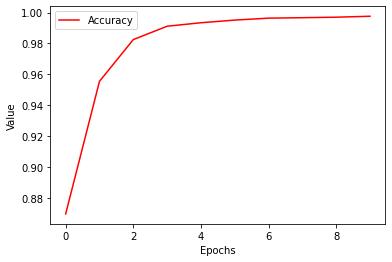

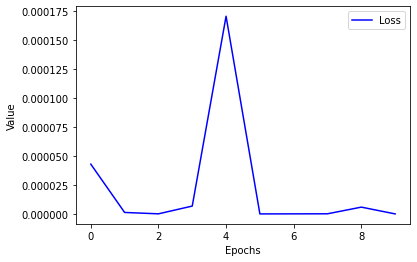

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('બીજી', 'JJ'), ('ધારાઓ', 'N_NN'), ('સુગમ', 'PSP'), ('અને', 'CC_CCD'), ('શાસ્ત્રીય', 'JJ'), ('સંગીતની', 'N_NN'), ('રહી', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('બે', 'QT_QTC'), ('કડીઓ', 'QT_QTC'), ('પર', 'PSP'), ('અંગ્રેજ', 'N_NNP'), ('સરકાર', 'N_NN'), ('ધૂંધવાઈ', 'N_NN'), ('ઊઠી', 'JJ'), ('.', 'RD_PUNC')]
[('વસંતે', 'N_NN'), ('દુકાન', 'N_NNP'), ('છોડીને', 'N_NN'), ('અનેક', 'JJ'), ('વેપાર', 'N_NN'), ('અને', 'CC_CCD'), ('વ્યવસાય', 'N_NN'), ('કરી', 'V_VM'), ('જોયા', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એ', 'DM_DMD'), ('પછી', 'PSP'), ('તો', 'RP_RPD'), ('મા.', 'N_NN'), ('વસંત', 'V_VAUX_VNP'), ('સંગીત', 'N_NN'), ('ક્ષેત્રના', 'PSP'), ('મહારથીઓ', 'N_NN'), ('ખાંસાહેબ', 'N_NN'), ('ફૈયાઝખાં', 'N_NN'), (',', 'RD_PUNC'), ('ખાંઅબ્દુલ', 'N_NN'), ('કરીમખાં', 'JJ'), (',', 'RD_PUNC'), ('બડે', 'JJ'), ('ગુલામઅલીખાં', 'N_NN'), (',', 'RD_PUNC'), ('કે.સી.ડ', 'N_NN'), (',', 'RD_PUNC'), ('પંકજ', 'N_NN'), ('મલિક', 'N_NN'), ('અને', 'CC_CCD'), ('કુંદનલાલ', 'N_NN'), ('સાયગલ', 'N_NN'), ('જેવ

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7620646244229963

In [ ]:
tags = ['N_NN', 'PR_PRL', 'JJ', 'V_VAUX_VNP', 'V_VAUX', 'N_NNP', 'RD_PUNC', 'DM_DMD', 'N_NST', 'PR_PRI', 'PR_PRP', 'V_VM', 'PSP', 'DM_DMI', 'RP_RPD', 'QT_QTF', 'RP_NEG', 'CC_CCD', 'QT_QTC', 'RD_SYM', 'CC_CCS', 'PR_PRF', 'PR_PRQ', 'DM_DMQ', 'CC_CCS_UT', 'PR_PRC', 'QT_QTO', 'RB', 'RD_RDF', 'DM_DMR','RP_INJ','RD_ECH','RP_INTF','RP_CL']
heading = ['guj_entertainment_sample3','guj_philosophy_sample4','guj_science and technology_sample6','guj_sports_sample7','guj_religion_sample5','guj_economy_sample2','guj_art and culture_sample1']
total_true = {}
total_false = {}

for i in tags:
  total_true[i] = 0;
  total_false[i]=0;

def evaluations(true,pred):
  dictt = {}
  for i in tags:
    dictt[i]={}
  
  for i in range(len(true)):
    if(true[i]==pred[i]):
      total_true[true[i]] += 1
      continue
    
    total_false[true[i]] += 1
    if(pred[i] in dictt[true[i]].keys()):
      dictt[true[i]][pred[i]] += 1
    else:
      dictt[true[i]][pred[i]] = 1
  return dictt

res = evaluations(y_true,y_pred)
print(res)

{'N_NN': {'QT_QTC': 25, 'N_NNP': 42, 'PSP': 30, 'JJ': 94, 'V_VAUX': 5, 'RD_PUNC': 17, 'V_VM': 24, 'DM_DMQ': 2, 'DM_DMD': 5, 'RD_RDF': 2, 'PR_PRP': 6, 'V_VAUX_VNP': 2, 'N_NST': 4, 'QT_QTF': 5, 'RP_NEG': 3, 'DM_DMI': 2, 'CC_CCD': 5, 'RB': 4, 'RP_RPD': 1, 'PR_PRQ': 1, 'QT_QTO': 2, 'PR_PRL': 3}, 'PR_PRL': {'N_NN': 1, 'N_NST': 1, 'DM_DMD': 2}, 'JJ': {'PSP': 17, 'RP_NEG': 3, 'QT_QTC': 6, 'V_VM': 13, 'N_NN': 85, 'RD_RDF': 2, 'PR_PRP': 4, 'V_VAUX_VNP': 3, 'CC_CCD': 4, 'N_NNP': 12, 'QT_QTF': 2, 'N_NST': 2, 'RD_PUNC': 4, 'DM_DMI': 1, 'DM_DMD': 2, 'V_VAUX': 1, 'QT_QTO': 1, 'PR_PRL': 1}, 'V_VAUX_VNP': {'N_NN': 118, 'V_VM': 41, 'PSP': 16, 'JJ': 33, 'QT_QTC': 6, 'CC_CCD': 2, 'RP_NEG': 3, 'QT_QTF': 3, 'PR_PRQ': 1, 'N_NNP': 12, 'V_VAUX': 8, 'RD_RDF': 1, 'PR_PRP': 1, 'DM_DMD': 1, 'N_NST': 2, 'CC_CCS_UT': 1, 'PR_PRL': 1, 'RP_RPD': 1}, 'V_VAUX': {'JJ': 1, 'V_VM': 31, 'N_NN': 5, 'RP_NEG': 1, 'N_NNP': 2, 'PSP': 1, 'RP_RPD': 1}, 'N_NNP': {'N_NN': 74, 'V_VAUX_VNP': 3, 'JJ': 17, 'V_VM': 7, 'CC_CCS': 2, 'PSP':

Text(0.5, 1.0, 'Correctly Predicted')

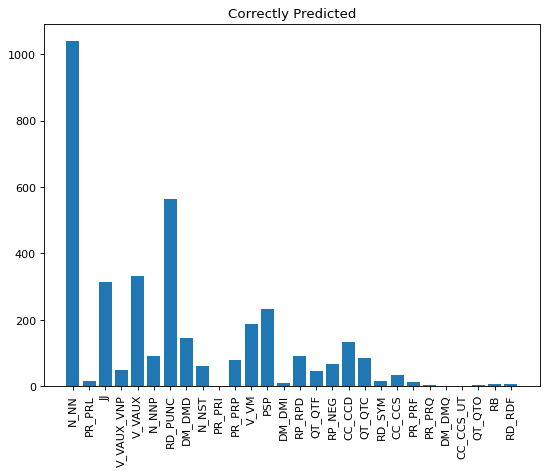

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(total_true)), list(total_true.values()), align='center')
plt.xticks(range(len(total_true)), list(total_true.keys()),rotation='vertical')
plt.title("Correctly Predicted")

Text(0.5, 1.0, 'Wrong Prediction')

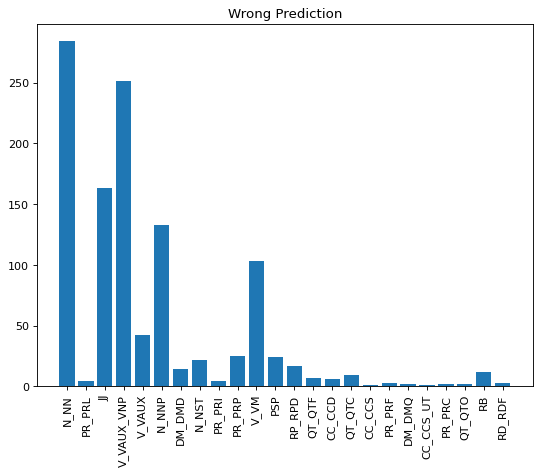

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(total_false)), list(total_false.values()), align='center')
plt.xticks(range(len(total_false)), list(total_false.keys()),rotation='vertical')
plt.title("Wrong Prediction")

In [ ]:
for i in res:
  total = 0
  print("Actual Value ",i)
  for j in res[i]:
    total += res[i][j]
  
  print(res[i])
  print("Total Wrong Prediction ",total)
  print("\n")
  print("*"*50)

Actual Value  N_NN
{'QT_QTC': 25, 'N_NNP': 42, 'PSP': 30, 'JJ': 94, 'V_VAUX': 5, 'RD_PUNC': 17, 'V_VM': 24, 'DM_DMQ': 2, 'DM_DMD': 5, 'RD_RDF': 2, 'PR_PRP': 6, 'V_VAUX_VNP': 2, 'N_NST': 4, 'QT_QTF': 5, 'RP_NEG': 3, 'DM_DMI': 2, 'CC_CCD': 5, 'RB': 4, 'RP_RPD': 1, 'PR_PRQ': 1, 'QT_QTO': 2, 'PR_PRL': 3}
Total Wrong Prediction  284


**************************************************
Actual Value  PR_PRL
{'N_NN': 1, 'N_NST': 1, 'DM_DMD': 2}
Total Wrong Prediction  4


**************************************************
Actual Value  JJ
{'PSP': 17, 'RP_NEG': 3, 'QT_QTC': 6, 'V_VM': 13, 'N_NN': 85, 'RD_RDF': 2, 'PR_PRP': 4, 'V_VAUX_VNP': 3, 'CC_CCD': 4, 'N_NNP': 12, 'QT_QTF': 2, 'N_NST': 2, 'RD_PUNC': 4, 'DM_DMI': 1, 'DM_DMD': 2, 'V_VAUX': 1, 'QT_QTO': 1, 'PR_PRL': 1}
Total Wrong Prediction  163


**************************************************
Actual Value  V_VAUX_VNP
{'N_NN': 118, 'V_VM': 41, 'PSP': 16, 'JJ': 33, 'QT_QTC': 6, 'CC_CCD': 2, 'RP_NEG': 3, 'QT_QTF': 3, 'PR_PRQ': 1, 'N_NNP': 1

### adam

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualBILSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualBILSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualBILSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.000304687107927748	Accuracy: 0.877284586429596
Epoch 4 Completed,	Loss 6.785429491174e-06	Accuracy: 0.9929492473602295
Epoch 6 Completed,	Loss 7.205419194633578e-07	Accuracy: 0.9988789260387421
Epoch 8 Completed,	Loss 1.0466064168213052e-05	Accuracy: 0.9942724704742432
Epoch 10 Completed,	Loss 1.0756341950468595e-07	Accuracy: 0.996932715177536
Epoch 12 Completed,	Loss 4.963474253827371e-08	Accuracy: 0.9998852014541626
Epoch 14 Completed,	Loss 2.0853737403569994e-08	Accuracy: 0.9999999403953552
Epoch 16 Completed,	Loss 8.75389893906231e-09	Accuracy: 0.9999999403953552
Epoch 18 Completed,	Loss 3.6808371906005277e-09	Accuracy: 0.9999999403953552
Epoch 20 Completed,	Loss 1.5416523613254185e-09	Accuracy: 0.9999999403953552


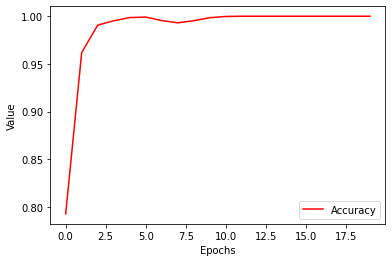

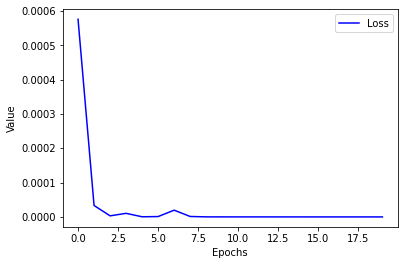

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('ભારતના', 'N_NNP'), ('ટેસ્ટ', 'N_NN'), ('ઇતિહાસની', 'N_NN'), ('ઑસ્ટ્રેલિયા', 'N_NNP'), ('સામે', 'PSP'), ('વિકેટની', 'JJ'), ('રીતે', 'N_NN'), ('સૌથી', 'JJ'), ('મોટી', 'JJ'), ('જીત', 'N_NN'), ('.', 'RD_PUNC')]
[('કે', 'CC_CCS'), ('તે', 'DM_DMD'), ('ત્રણે', 'JJ'), ('ય', 'RP_RPD'), ('ફોરમેટનો', 'N_NN'), ('બોલર', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વનડેમાં', 'N_NN'), ('કેરમ', 'N_NN'), ('બોલ', 'N_NN'), ('સ્લો', 'JJ'), ('રીલીઝ', 'N_NN'), ('બોલ', 'N_NN'), ('ફેંકી', 'N_NN'), ('શકાય', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તે', 'DM_DMD'), ('વેધક', 'N_NN'), ('પૂરવાર', 'JJ'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આમ', 'PSP'), ('તેની', 'DM_DMD'), ('બોલિંગ', 'N_NN'), ('જૂની', 'JJ'), ('પરંપરાગત', 'N_NN'), ('પદ્ધતિ', 'N_NN'), ('કહી', 'V_VM'), ('શકાય', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પૂજારાએ', 'N_NNP'), ('કારકિર્દીમાં', 'N_NN'), ('ત્રીજી', 'QT_QTO'), ('વખત', 'N_NN'), ('૧૫૦થી', 'QT_QTC'), ('વધુનો', 'QT_QTF'), ('સ્કોર', 'N_NN'), ('કરતાં', 'N_NNP'), ('૨૫૧', 'N_NNP'), ('બોલમાં', 'N

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.8261437908496732

In [ ]:
tags = ['N_NN', 'PR_PRL', 'JJ', 'V_VAUX_VNP', 'V_VAUX', 'N_NNP', 'RD_PUNC', 'DM_DMD', 'N_NST', 'PR_PRI', 'PR_PRP', 'V_VM', 'PSP', 'DM_DMI', 'RP_RPD', 'QT_QTF', 'RP_NEG', 'CC_CCD', 'QT_QTC', 'RD_SYM', 'CC_CCS', 'PR_PRF', 'PR_PRQ', 'DM_DMQ', 'CC_CCS_UT', 'PR_PRC', 'QT_QTO', 'RB', 'RD_RDF', 'DM_DMR','RP_INJ','RD_ECH','RP_INTF','RP_CL']
heading = ['guj_entertainment_sample3','guj_philosophy_sample4','guj_science and technology_sample6','guj_sports_sample7','guj_religion_sample5','guj_economy_sample2','guj_art and culture_sample1']
total_true = {}
total_false = {}

for i in tags:
  total_true[i] = 0;
  total_false[i]=0;

def evaluations(true,pred):
  dictt = {}
  for i in tags:
    dictt[i]={}
  
  for i in range(len(true)):
    if(true[i]==pred[i]):
      total_true[true[i]] += 1
      continue
    
    total_false[true[i]] += 1
    if(pred[i] in dictt[true[i]].keys()):
      dictt[true[i]][pred[i]] += 1
    else:
      dictt[true[i]][pred[i]] = 1
  return dictt

res = evaluations(y_true,y_pred)
print(res)

{'N_NN': {'JJ': 5, 'N_NNP': 13, 'PSP': 4, 'V_VM': 2}, 'PR_PRL': {'DM_DMD': 1}, 'JJ': {'N_NN': 15, 'N_NNP': 4, 'PSP': 1}, 'V_VAUX_VNP': {'N_NNP': 4, 'PSP': 7, 'N_NN': 14, 'N_NST': 1, 'V_VM': 9, 'JJ': 2, 'V_VAUX': 2, 'PR_PRP': 1}, 'V_VAUX': {'N_NN': 3, 'N_NNP': 1}, 'N_NNP': {'N_NN': 8, 'JJ': 3}, 'RD_PUNC': {}, 'DM_DMD': {'PR_PRP': 3, 'JJ': 1}, 'N_NST': {'JJ': 2}, 'PR_PRI': {}, 'PR_PRP': {'DM_DMD': 1}, 'V_VM': {'N_NN': 7, 'V_VAUX_VNP': 3, 'N_NNP': 1, 'V_VAUX': 1, 'QT_QTC': 1}, 'PSP': {'N_NNP': 3, 'N_NN': 2, 'N_NST': 1}, 'DM_DMI': {'PSP': 1}, 'RP_RPD': {}, 'QT_QTF': {}, 'RP_NEG': {}, 'CC_CCD': {}, 'QT_QTC': {'JJ': 2, 'N_NNP': 2, 'QT_QTO': 1}, 'RD_SYM': {}, 'CC_CCS': {}, 'PR_PRF': {}, 'PR_PRQ': {}, 'DM_DMQ': {}, 'CC_CCS_UT': {}, 'PR_PRC': {}, 'QT_QTO': {}, 'RB': {'PSP': 1}, 'RD_RDF': {}, 'DM_DMR': {}, 'RP_INJ': {}, 'RD_ECH': {}, 'RP_INTF': {}, 'RP_CL': {}}


In [ ]:
for i in list(total_true):
  if(total_true[i]==0):
    total_true.pop(i)

for i in list(total_false):
  if(total_false[i]==0):
    total_false.pop(i)

Text(0.5, 1.0, 'Correctly Predicted')

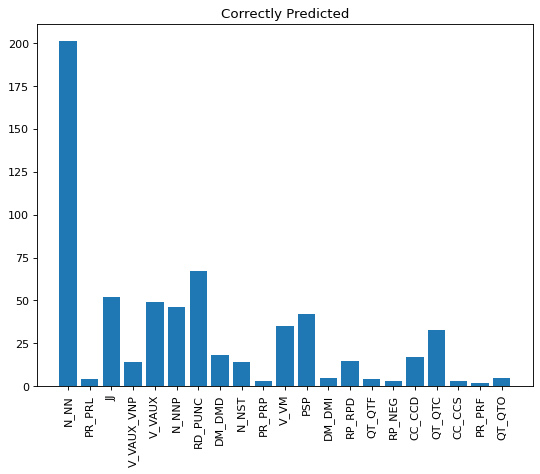

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(total_true)), list(total_true.values()), align='center')
plt.xticks(range(len(total_true)), list(total_true.keys()),rotation='vertical')
plt.title("Correctly Predicted")

Text(0.5, 1.0, 'Wrong Prediction')

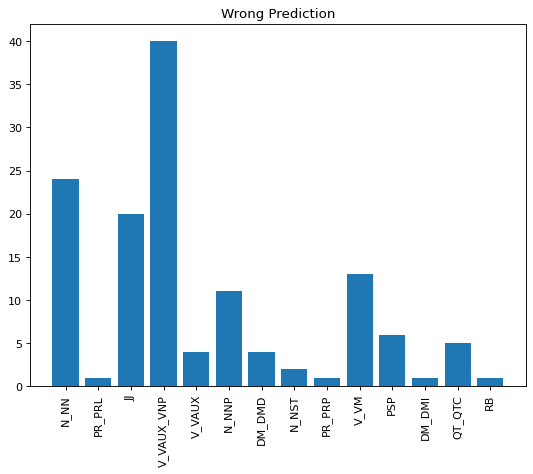

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(total_false)), list(total_false.values()), align='center')
plt.xticks(range(len(total_false)), list(total_false.keys()),rotation='vertical')
plt.title("Wrong Prediction")

In [ ]:
for i in res:
  total = 0
  print("Actual Value ",i)
  for j in res[i]:
    total += res[i][j]
  
  print(res[i])
  print("Total Wrong Prediction ",total)
  print("\n")
  print("*"*50)

Actual Value  N_NN
{'JJ': 5, 'N_NNP': 13, 'PSP': 4, 'V_VM': 2}
Total Wrong Prediction  24


**************************************************
Actual Value  PR_PRL
{'DM_DMD': 1}
Total Wrong Prediction  1


**************************************************
Actual Value  JJ
{'N_NN': 15, 'N_NNP': 4, 'PSP': 1}
Total Wrong Prediction  20


**************************************************
Actual Value  V_VAUX_VNP
{'N_NNP': 4, 'PSP': 7, 'N_NN': 14, 'N_NST': 1, 'V_VM': 9, 'JJ': 2, 'V_VAUX': 2, 'PR_PRP': 1}
Total Wrong Prediction  40


**************************************************
Actual Value  V_VAUX
{'N_NN': 3, 'N_NNP': 1}
Total Wrong Prediction  4


**************************************************
Actual Value  N_NNP
{'N_NN': 8, 'JJ': 3}
Total Wrong Prediction  11


**************************************************
Actual Value  RD_PUNC
{}
Total Wrong Prediction  0


**************************************************
Actual Value  DM_DMD
{'PR_PRP': 3, 'JJ': 1}
Total Wrong Predicti

In [ ]:
import pandas as pd
temp = {'JJ':{'RP_RPD': 1, 'N_NN': 25, 'PSP': 6, 'N_NST': 4, 'N_NNP': 11, 'RD_RDF': 1, 'V_VAUX_VNP': 2, 'V_VM': 2, 'QT_QTC': 1, 'RD_SYM': 1, 'QT_QTF': 2, 'QT_QTO': 3, 'DM_DMQ': 2, 'PR_PRF': 1}}
data = pd.DataFrame.from_dict(temp)
data


,JJ
DM_DMQ,2
N_NN,25
N_NNP,11
N_NST,4
PR_PRF,1
PSP,6
QT_QTC,1
QT_QTF,2
QT_QTO,3
RD_RDF,1


### SGD

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualBILSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualBILSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualBILSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.005955092841759324	Accuracy: 0.3549381047487259
Epoch 4 Completed,	Loss 0.00496686645783484	Accuracy: 0.4557008296251297
Epoch 6 Completed,	Loss 0.004259674344211817	Accuracy: 0.4603702276945114
Epoch 8 Completed,	Loss 0.0037919810274615884	Accuracy: 0.4781694561243057
Epoch 10 Completed,	Loss 0.003455196041613817	Accuracy: 0.5076101124286652
Epoch 12 Completed,	Loss 0.003211375209502876	Accuracy: 0.5426437854766846
Epoch 14 Completed,	Loss 0.0030296584591269493	Accuracy: 0.5752701461315155
Epoch 16 Completed,	Loss 0.002882003434933722	Accuracy: 0.5997283160686493
Epoch 18 Completed,	Loss 0.0027511698426678777	Accuracy: 0.6220861077308655
Epoch 20 Completed,	Loss 0.0026283658808097243	Accuracy: 0.6422010064125061


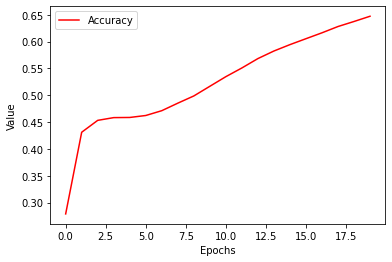

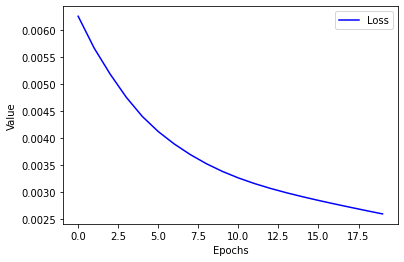

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('ભારતના', 'N_NNP'), ('ટેસ્ટ', 'N_NN'), ('ઇતિહાસની', 'N_NNP'), ('ઑસ્ટ્રેલિયા', 'N_NNP'), ('સામે', 'PSP'), ('વિકેટની', 'N_NN'), ('રીતે', 'N_NN'), ('સૌથી', 'JJ'), ('મોટી', 'JJ'), ('જીત', 'V_VM'), ('.', 'RD_PUNC')]
[('કે', 'CC_CCS'), ('તે', 'DM_DMD'), ('ત્રણે', 'JJ'), ('ય', 'N_NN'), ('ફોરમેટનો', 'N_NN'), ('બોલર', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વનડેમાં', 'N_NN'), ('કેરમ', 'N_NN'), ('બોલ', 'N_NN'), ('સ્લો', 'N_NN'), ('રીલીઝ', 'N_NN'), ('બોલ', 'N_NN'), ('ફેંકી', 'V_VM'), ('શકાય', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તે', 'DM_DMD'), ('વેધક', 'N_NN'), ('પૂરવાર', 'N_NN'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આમ', 'N_NN'), ('તેની', 'DM_DMD'), ('બોલિંગ', 'N_NN'), ('જૂની', 'N_NN'), ('પરંપરાગત', 'N_NN'), ('પદ્ધતિ', 'N_NN'), ('કહી', 'V_VM'), ('શકાય', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પૂજારાએ', 'N_NNP'), ('કારકિર્દીમાં', 'N_NN'), ('ત્રીજી', 'N_NN'), ('વખત', 'N_NN'), ('૧૫૦થી', 'N_NN'), ('વધુનો', 'N_NN'), ('સ્કોર', 'N_NN'), ('કરતાં', 'N_NN'), ('૨૫૧', 'N_NN'), ('બોલમાં', 'N

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.6274509803921569

In [ ]:
tags = ['N_NN', 'PR_PRL', 'JJ', 'V_VAUX_VNP', 'V_VAUX', 'N_NNP', 'RD_PUNC', 'DM_DMD', 'N_NST', 'PR_PRI', 'PR_PRP', 'V_VM', 'PSP', 'DM_DMI', 'RP_RPD', 'QT_QTF', 'RP_NEG', 'CC_CCD', 'QT_QTC', 'RD_SYM', 'CC_CCS', 'PR_PRF', 'PR_PRQ', 'DM_DMQ', 'CC_CCS_UT', 'PR_PRC', 'QT_QTO', 'RB', 'RD_RDF', 'DM_DMR','RP_INJ','RD_ECH','RP_INTF','RP_CL']
heading = ['guj_entertainment_sample3','guj_philosophy_sample4','guj_science and technology_sample6','guj_sports_sample7','guj_religion_sample5','guj_economy_sample2','guj_art and culture_sample1']
total_true = {}
total_false = {}

for i in tags:
  total_true[i] = 0;
  total_false[i]=0;

def evaluations(true,pred):
  dictt = {}
  for i in tags:
    dictt[i]={}
  
  for i in range(len(true)):
    if(true[i]==pred[i]):
      total_true[true[i]] += 1
      continue
    
    total_false[true[i]] += 1
    if(pred[i] in dictt[true[i]].keys()):
      dictt[true[i]][pred[i]] += 1
    else:
      dictt[true[i]][pred[i]] = 1
  return dictt

res = evaluations(y_true,y_pred)
print(res)

{'N_NN': {'N_NNP': 9, 'V_VM': 5, 'RD_PUNC': 4, 'JJ': 3}, 'PR_PRL': {'N_NN': 2, 'DM_DMD': 1}, 'JJ': {'N_NN': 54, 'V_VM': 2, 'PSP': 1, 'N_NNP': 1}, 'V_VAUX_VNP': {'N_NN': 32, 'CC_CCD': 1, 'JJ': 1, 'V_VM': 8, 'V_VAUX': 2, 'N_NNP': 2, 'RD_PUNC': 1}, 'V_VAUX': {'V_VM': 5, 'N_NN': 1}, 'N_NNP': {'N_NN': 35, 'PSP': 1}, 'RD_PUNC': {}, 'DM_DMD': {'PR_PRP': 2, 'N_NN': 2, 'PSP': 1}, 'N_NST': {'N_NN': 9, 'V_VM': 1}, 'PR_PRI': {}, 'PR_PRP': {'DM_DMD': 2, 'V_VM': 1, 'N_NNP': 1}, 'V_VM': {'N_NN': 16}, 'PSP': {'N_NN': 17, 'N_NNP': 3, 'V_VM': 1}, 'DM_DMI': {'N_NN': 6}, 'RP_RPD': {'N_NN': 2}, 'QT_QTF': {'N_NN': 3, 'V_VM': 1}, 'RP_NEG': {'V_VAUX': 1, 'N_NN': 1}, 'CC_CCD': {'N_NN': 4, 'RP_RPD': 1}, 'QT_QTC': {'JJ': 3, 'N_NN': 27, 'N_NNP': 2}, 'RD_SYM': {}, 'CC_CCS': {}, 'PR_PRF': {'N_NNP': 1, 'N_NN': 1}, 'PR_PRQ': {}, 'DM_DMQ': {}, 'CC_CCS_UT': {}, 'PR_PRC': {}, 'QT_QTO': {'N_NN': 3, 'JJ': 1}, 'RB': {'N_NN': 1}, 'RD_RDF': {}, 'DM_DMR': {}, 'RP_INJ': {}, 'RD_ECH': {}, 'RP_INTF': {}, 'RP_CL': {}}


In [ ]:
for i in list(total_true):
  if(total_true[i]==0):
    total_true.pop(i)

for i in list(total_false):
  if(total_false[i]==0):
    total_false.pop(i)

Text(0.5, 1.0, 'Correctly Predicted')

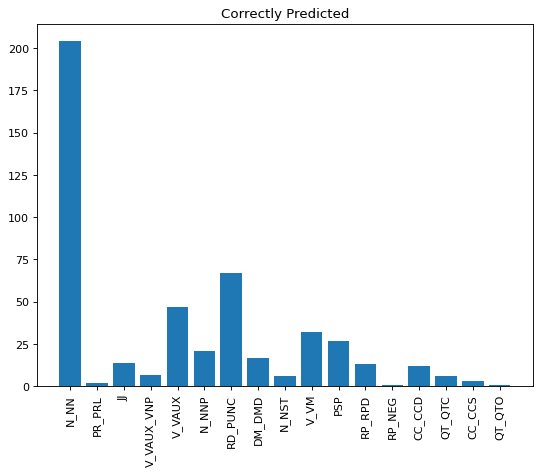

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(total_true)), list(total_true.values()), align='center')
plt.xticks(range(len(total_true)), list(total_true.keys()),rotation='vertical')
plt.title("Correctly Predicted")

Text(0.5, 1.0, 'Wrong Prediction')

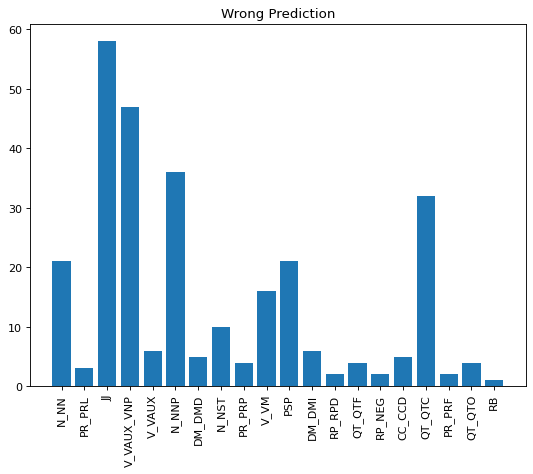

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(total_false)), list(total_false.values()), align='center')
plt.xticks(range(len(total_false)), list(total_false.keys()),rotation='vertical')
plt.title("Wrong Prediction")

In [ ]:
for i in res:
  total = 0
  print("Actual Value ",i)
  for j in res[i]:
    total += res[i][j]
  
  print(res[i])
  print("Total Wrong Prediction ",total)
  print("\n")
  print("*"*50)

Actual Value  N_NN
{'N_NNP': 9, 'V_VM': 5, 'RD_PUNC': 4, 'JJ': 3}
Total Wrong Prediction  21


**************************************************
Actual Value  PR_PRL
{'N_NN': 2, 'DM_DMD': 1}
Total Wrong Prediction  3


**************************************************
Actual Value  JJ
{'N_NN': 54, 'V_VM': 2, 'PSP': 1, 'N_NNP': 1}
Total Wrong Prediction  58


**************************************************
Actual Value  V_VAUX_VNP
{'N_NN': 32, 'CC_CCD': 1, 'JJ': 1, 'V_VM': 8, 'V_VAUX': 2, 'N_NNP': 2, 'RD_PUNC': 1}
Total Wrong Prediction  47


**************************************************
Actual Value  V_VAUX
{'V_VM': 5, 'N_NN': 1}
Total Wrong Prediction  6


**************************************************
Actual Value  N_NNP
{'N_NN': 35, 'PSP': 1}
Total Wrong Prediction  36


**************************************************
Actual Value  RD_PUNC
{}
Total Wrong Prediction  0


**************************************************
Actual Value  DM_DMD
{'PR_PRP': 2, 'N_NN': 2, 

In [ ]:
import pandas as pd
temp = {'JJ':{'RP_RPD': 1, 'N_NN': 25, 'PSP': 6, 'N_NST': 4, 'N_NNP': 11, 'RD_RDF': 1, 'V_VAUX_VNP': 2, 'V_VM': 2, 'QT_QTC': 1, 'RD_SYM': 1, 'QT_QTF': 2, 'QT_QTO': 3, 'DM_DMQ': 2, 'PR_PRF': 1}}
data = pd.DataFrame.from_dict(temp)
data


,JJ
DM_DMQ,2
N_NN,25
N_NNP,11
N_NST,4
PR_PRF,1
PSP,6
QT_QTC,1
QT_QTF,2
QT_QTO,3
RD_RDF,1


# Each Corpus RMS BILSTM

In [ ]:
Acc_plot = []
Loss_plot = []
precision_plot = []
f1score_plot = []

dict_true = {}
dict_pred = {}

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os


recall = []
Acc_plot = []
Loss_plot = []
precision_plot = []
f1score_plot = []



## guj_sports_sample7

In [ ]:
path = '/content/drive/MyDrive/nlpproject/data/guj_sports_sample7.txt'
                
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 4269
Unique tags: 29
Unique characters: 107


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('ચેન્નઈમાં', 'N_NNP'), ('રમાયેલી', 'V_VAUX_VNP'), ('ઑસ્ટ્રેલિયાની', 'N_NNP'), ('સામેની', 'PSP'), ('પ્રથમ', 'QT_QTO'), ('ટેસ્ટમાં', 'N_NN'), ('ભારતીય', 'JJ'), ('સ્પિનરો', 'N_NN'), ('(', 'RD_SYM'), ('અશ્વિન', 'N_NNP'), (',', 'RD_PUNC'), ('હરભજન', 'N_NNP'), ('અને', 'CC_CCD'), ('જાડેજાએ', 'N_NNP'), ('તમામ', 'JJ'), ('૨૦', 'QT_QTC'), ('વિકેટ', 'N_NN'), ('ઝડપવાની', 'V_VAUX_VNP'), ('અનોખી', 'JJ'), ('સિદ્ધિ', 'N_NN'), ('મેળવી', 'V_VAUX_VNP'), ('હતી', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 3 Completed,	Loss 6.739230381451004e-05	Accuracy: 0.9067578514417013
Epoch 6 Completed,	Loss 6.769671756501339e-07	Accuracy: 0.9967535535494486
Epoch 9 Completed,	Loss 2.643132388513436e-07	Accuracy: 0.9993270834287008
Epoch 12 Completed,	Loss 6.706110259694735e-09	Accuracy: 0.9994250138600668
Epoch 15 Completed,	Loss 8.226107966099091e-10	Accuracy: 0.9997540513674418
Epoch 18 Completed,	Loss 3.7575026516171546e-09	Accuracy: 0.9997178713480631
Epoch 21 Completed,	Loss 6.699205021739226e-09	Accuracy: 0.9998346964518229
Epoch 24 Completed,	Loss 2.7885209188024025e-11	Accuracy: 0.9997866749763489
Epoch 27 Completed,	Loss 1.3942605172253172e-11	Accuracy: 0.9998419086138407
Epoch 30 Completed,	Loss 2.649091594234913e-10	Accuracy: 0.999676505724589


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('ટેસ્ટમાં', 'N_NN'), ('અશ્વિને', 'PSP'), ('વૈવિધ્યતા', 'N_NN'), ('સાથે', 'PSP'), ('ઓફ', 'PSP'), ('સ્પિન', 'N_NN'), ('બોલિંગ', 'N_NN'), ('પર', 'PSP'), ('જ', 'RP_RPD'), ('મદાર', 'N_NN'), ('રાખ્યો', 'V_VAUX'), ('હતો', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ચારને', 'QT_QTC'), ('ન્યાય', 'N_NN'), ('કરવામાં', 'N_NN'), ('પ્રભાવ', 'V_VAUX'), ('પણ', 'RP_RPD'), ('તૂટી', 'V_VAUX_VNP'), ('જઈ', 'V_VAUX_VNP'), ('શકે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ચેન્નઈમાં', 'N_NNP'), ('રમાયેલી', 'N_NNP'), ('ઑસ્ટ્રેલિયાની', 'N_NNP'), ('સામેની', 'PSP'), ('પ્રથમ', 'QT_QTO'), ('ટેસ્ટમાં', 'N_NN'), ('ભારતીય', 'JJ'), ('સ્પિનરો', 'N_NN'), ('(', 'RD_SYM'), ('અશ્વિન', 'N_NNP'), (',', 'RD_PUNC'), ('હરભજન', 'N_NNP'), ('અને', 'CC_CCD'), ('જાડેજાએ', 'N_NNP'), ('તમામ', 'JJ'), ('૨૦', 'QT_QTC'), ('વિકેટ', 'N_NN'), ('ઝડપવાની', 'N_NN'), ('અનોખી', 'N_NN'), ('સિદ્ધિ', 'N_NN'), ('મેળવી', 'V_VM'), ('હતી', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('સાથે', 'PSP'), ('ભારતે', 'N_NNP'), ('ઘરઆંગણે', 'N_NN'), ('સૌથી', 'JJ'), ('વધુ', 'QT_QTF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('ઑસ્ટ્રેલિયાની', 'N_NNP'), ('ટીમ', 'N_NN'), ('કેપ્ટન', 'N_NN'), ('ક્લાર્ક', 'N_NN'), ('પર', 'PSP'), ('ખૂબ', 'QT_QTF'), ('જ', 'RP_RPD'), ('આધાર', 'N_NN'), ('રાખે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ઓલરાઉન્ડરો', 'N_NN'), ('હેનરિક્સ', 'N_NNP'), ('અને', 'CC_CCD'), ('મેક્સવેલ', 'N_NN'), ('પણ', 'RP_RPD'), ('સાવ', 'PSP'), ('ફ્લોપ', 'N_NN'), ('રહ્યા', 'V_VM'), ('હતા', 'V_VAUX'), ('.', 'RD_PUNC')]
[('બાસ્કેટબૉલમાં', 'N_NN'), ('પોતાની', 'PR_PRF'), ('પાસે', 'PSP'), ('રહેલા', 'JJ'), ('દડાને', 'N_NN'), ('પોતાના', 'PR_PRF'), ('પક્ષના', 'N_NN'), ('ખેલાડી', 'N_NN'), ('તરફ', 'PSP'), ('મોકલવાના', 'V_VAUX_VNP'), ('કૌશલ્યને', 'N_NN'), ('`', 'RD_PUNC'), ('પાસિંગ', 'N_NN'), ('`', 'RD_PUNC'), ('કહેવામાં', 'N_NN'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('દાવ', 'N_NN'), ('લેનાર', 'V_VAUX_VNP'), ('ખેલાડી', 'N_NN'), ('બારી', 'N_NN'), ('પાસેથી', 'PSP'), ('પસાર', 'JJ'), ('થતો', 'V_VAUX_VNP'), ('હોય', 'V_VAUX'), ('તે', 'DM_DMD'), ('વખતે', 'N_NN'), ('ખો', 'N_NN'), ('મળ્યા', 'V_VAUX_

In [ ]:
dict_true['sports'] = y_true
dict_pred['sports'] = y_pred

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
accuracy_score(y_true, y_pred)
f1_score(y_true, y_pred, average='macro')

0.789177651024038

## guj_science

In [ ]:
path = '/content/drive/MyDrive/nlpproject/data/guj_science and technology_sample6.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 5544
Unique tags: 31
Unique characters: 131


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('જેનાં', 'PR_PRL'), ('સંપૂર્ણ', 'JJ'), ('પરિણામો', 'N_NN'), ('હજી', 'N_NST'), ('ગણવાનાં', 'V_VAUX_VNP'), ('બાકી', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 3 Completed,	Loss 0.0007682990379862531	Accuracy: 0.9089152812957764


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
dict_true['science'] = y_true
dict_pred['science'] = y_pred

## guj_economy_sample2.txt

In [ ]:
path = '/content/drive/MyDrive/nlpproject/data/guj_economy_sample2.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
dict_true['economy'] = y_true
dict_pred['economy'] = y_pred

## guj_entertainment_sample3

In [ ]:
path = '/content/drive/MyDrive/nlpproject/data/guj_entertainment_sample3.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
dict_true['entern'] = y_true
dict_pred['entern'] = y_pred

## guj_philosophy_sample4

In [ ]:
path = '/content/drive/MyDrive/nlpproject/data/guj_philosophy_sample4.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
dict_true['philosophy'] = y_true
dict_pred['philosophy'] = y_pred

## guj_religion_sample5.txt

In [ ]:
path = '/content/drive/MyDrive/nlpproject/data/guj_religion_sample5.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
dict_true['religion'] = y_true
dict_pred['religion'] = y_pred

## guj_art and culture_sample1

In [ ]:
path = '/content/drive/MyDrive/nlpproject/data/guj_art and culture_sample1.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
dict_true['art culture'] = y_true
dict_pred['art culture'] = y_pred

In [ ]:
k = dict_true.keys()
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

for i in k:
  y_true = dict_true[i]
  y_pred = dict_pred[i]
  print(y_true)
  print(y_pred)
  Acc_plot.append(accuracy_score(y_true, y_pred))
  recall.append(recall_score(y_true,y_pred,average='macro'))
  precision_plot.append(precision_score(y_true,y_pred,average='macro'))
  f1score_plot.append(f1_score(y_true, y_pred,average='macro'))

print(Acc_plot)
print(recall)
print(precision_plot)
print(f1score_plot)

# Each Corpus Adam Bilstm

In [ ]:
Acc_plot = []
recall = []
precision_plot = []
f1score_plot = []

dict_true = {}
dict_pred = {}

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

## guj_sports_sample7

In [ ]:
# path = '/content/drive/MyDrive/nlpproject/data/guj_sports_sample7.txt'
path = '/content/temp/guj_sports_sample7.txt'
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 4269
Unique tags: 29
Unique characters: 107


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('પૂજારાએ', 'N_NNP'), ('૧૧', 'QT_QTC'), ('ટેસ્ટમાં', 'N_NN'), ('ત્રીજી', 'QT_QTO'), ('વખત', 'N_NN'), ('૧૫૦થી', 'QT_QTC'), ('વધુનો', 'QT_QTF'), ('સ્કોર', 'N_NN'), ('નોંધાવ્યો', 'V_VM'), ('હતો', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.0006175466987770051	Accuracy: 0.8751941323280334
Epoch 4 Completed,	Loss 5.504686964741268e-05	Accuracy: 0.9938141405582428
Epoch 6 Completed,	Loss 4.457262264168094e-05	Accuracy: 0.9976397454738617
Epoch 8 Completed,	Loss 9.736185802466935e-06	Accuracy: 0.9896542429924011
Epoch 10 Completed,	Loss 4.768382666497928e-07	Accuracy: 0.9991390109062195
Epoch 12 Completed,	Loss 1.4801383230178544e-07	Accuracy: 0.9999999403953552
Epoch 14 Completed,	Loss 7.142159574868856e-08	Accuracy: 0.9999999403953552
Epoch 16 Completed,	Loss 3.0818072538352226e-08	Accuracy: 0.9999999403953552
Epoch 18 Completed,	Loss 1.2690450024166466e-08	Accuracy: 0.9999999403953552
Epoch 20 Completed,	Loss 5.044418438515663e-09	Accuracy: 0.9999999403953552


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('જે', 'PR_PRL'), ('પછી', 'PSP'), ('ભારતે', 'N_NNP'), ('જીતવા', 'N_NN'), ('માટેના', 'PSP'), ('૫૦', 'QT_QTC'), ('રનના', 'N_NN'), ('પડકારને', 'N_NN'), ('લંચની', 'V_VAUX_VNP'), ('૪૦', 'QT_QTC'), ('મિનિટ', 'N_NN'), ('અગાઉ', 'PSP'), ('જ', 'RP_RPD'), ('૧૧.૩', 'QT_QTC'), ('ઓવરમાં', 'N_NNP'), ('બે', 'QT_QTC'), ('વિકેટ', 'N_NN'), ('ગુમાવીને', 'N_NN'), ('જીતી', 'V_VM'), ('લીધો', 'V_VAUX'), ('હતો', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એસએસાઈના', 'JJ'), ('નિર્ણયથી', 'N_NNP'), ('ભારતને', 'N_NNP'), ('અઝલાન', 'N_NNP'), ('શાહ', 'N_NNP'), ('કપમાંથી', 'N_NNP'), ('ખસી', 'N_NN'), ('જવાની', 'N_NN'), ('સ્થિતિ', 'N_NN'), ('સર્જાઈ', 'V_VM'), ('હતી', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પૂજારાએ', 'N_NNP'), ('૧૧', 'QT_QTC'), ('ટેસ્ટમાં', 'N_NN'), ('ત્રીજી', 'QT_QTO'), ('વખત', 'N_NN'), ('૧૫૦થી', 'QT_QTC'), ('વધુનો', 'QT_QTF'), ('સ્કોર', 'N_NN'), ('નોંધાવ્યો', 'JJ'), ('હતો', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સૌરાષ્ટ્રના', 'N_NNP'), ('સ્ટાર', 'JJ'), ('બેટ્સમેન', 'N_NN'), ('ચેતેશ્વર', 'N_NNP'), ('પૂજારાની', 'N_NNP'), ('કારકિર

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('પૂજારાએ', 'N_NNP'), ('બેવડી', 'JJ'), ('સદી', 'N_NN'), ('ફટકાર્યા', 'N_NN'), ('પછી', 'PSP'), ('મીડિયાને', 'N_NN'), ('એવું', 'JJ'), ('જણાવ્યું', 'V_VM'), ('હતું', 'V_VAUX'), ('કે', 'CC_CCS'), ('તેને', 'PR_PRP'), ('ખરી', 'JJ'), ('ખુશી', 'N_NN'), ('વિદેશની', 'N_NN'), ('ભૂમિ', 'N_NN'), ('પર', 'PSP'), ('એ', 'DM_DMD'), ('રીતે', 'N_NN'), ('રનની', 'N_NN'), ('હારમાળા', 'N_NN'), ('સર્જી', 'N_NN'), ('શકું', 'JJ'), ('તો', 'RP_RPD'), ('થાય', 'V_VM'), ('.', 'RD_PUNC')]
[('ખાસ', 'JJ'), ('કરીને', 'JJ'), ('ગુજરાત', 'N_NNP'), (',', 'RD_PUNC'), ('મહારાષ્ટ્ર', 'N_NNP'), (',', 'RD_PUNC'), ('આંધ્રપ્રદેશ', 'V_VAUX'), (',', 'RD_PUNC'), ('તમિલનાડુ', 'JJ'), (',', 'RD_PUNC'), ('બંગાળ', 'N_NN'), (',', 'RD_PUNC'), ('પંજાબ', 'N_NN'), ('અને', 'CC_CCD'), ('મધ્યપ્રદેશમાં', 'JJ'), ('આ', 'DM_DMD'), ('રમત', 'N_NN'), ('સવિશેષ', 'N_NN'), ('રમાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('ક્રિયા', 'N_NN'), ('ખૂબ', 'QT_QTF'), ('ઝડપથી', 'RB'), ('થાય', 'V_VM'), ('તે', 'DM_DMD'), ('જરૂરી', 'JJ'), ('છે',

In [ ]:
dict_true['sports'] = y_true
dict_pred['sports'] = y_pred

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
accuracy_score(y_true, y_pred)
f1_score(y_true, y_pred, average='macro')

0.7867963029442246

## guj_science

In [ ]:
# path = '/content/drive/MyDrive/nlpproject/data/guj_science and technology_sample6.txt'
path = '/content/temp/guj_science and technology_sample6.txt'
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 5544
Unique tags: 31
Unique characters: 131


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('વસ્તીના', 'N_NN'), ('પ્રભાવને', 'N_NN'), ('તેમાં', 'DM_DMD'), ('દરમિયાનગીરી', 'N_NN'), ('વડે', 'PSP'), ('ઉકેલવાની', 'V_VAUX_VNP'), ('તકો', 'N_NN'), ('સ્પષ્ટ', 'JJ'), ('કરે', 'V_VM'), ('છે', 'V_VAUX'), ('અને', 'CC_CCD'), ('તેમાં', 'DM_DMD'), ('મહત્તમ', 'JJ'), ('પરિણામો', 'N_NN'), ('લાવવા', 'V_VAUX_VNP'), ('જરૂરી', 'JJ'), ('યા', 'PSP'), ('ઉપલબ્ધ', 'JJ'), ('નીતિઓનો', 'N_NN'), ('પ્રકાર', 'N_NN'), ('સ્પષ્ટ', 'JJ'), ('કરે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.00016884776368897292	Accuracy: 0.8791282176971436
Epoch 4 Completed,	Loss 1.7635610447541694e-06	Accuracy: 0.9939098954200745
Epoch 6 Completed,	Loss 8.915729381442361e-07	Accuracy: 0.9993121325969696
Epoch 8 Completed,	Loss 7.574565711365722e-05	Accuracy: 0.9923302829265594
Epoch 10 Completed,	Loss 2.266255521021776e-07	Accuracy: 0.9983084499835968
Epoch 12 Completed,	Loss 9.990799654246985e-08	Accuracy: 0.9998319745063782
Epoch 14 Completed,	Loss 3.470520315573822e-08	Accuracy: 0.9999999403953552
Epoch 16 Completed,	Loss 1.5659030516701478e-08	Accuracy: 0.9999999403953552
Epoch 18 Completed,	Loss 6.556468701290896e-09	Accuracy: 0.9999999403953552
Epoch 20 Completed,	Loss 2.6037753064755975e-09	Accuracy: 0.9999999403953552


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('વધુમાં', 'JJ'), (',', 'RD_PUNC'), ('વિકાસ', 'N_NN'), ('પામતા', 'QT_QTC'), ('સમાજને', 'N_NN'), ('સંતોષવા', 'N_NN'), ('આયોજન', 'N_NN'), ('સાધવાની', 'JJ'), ('સરકારની', 'N_NN'), ('ક્ષમતા', 'N_NN'), ('ઉપર', 'PSP'), ('તે', 'DM_DMD'), ('પોતાનો', 'PR_PRF'), ('પ્રચંડ', 'N_NN'), ('પ્રભાવ', 'N_NN'), ('જમાવે', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સ્ત્રીઓ', 'N_NN'), ('વસ્તી', 'N_NN'), ('આયોજન', 'N_NN'), ('ઝૂંબેશમાં', 'N_NN'), ('દેખીતી', 'JJ'), ('રીતે', 'N_NN'), ('મહત્ત્વનો', 'JJ'), ('ભાગ', 'N_NN'), ('ભજવી', 'V_VM'), ('શકે', 'V_VAUX'), ('છે', 'V_VAUX'), ('અને', 'CC_CCD'), ('એની', 'DM_DMD'), ('સાથે', 'PSP'), ('પર્યાવરણની', 'N_NN'), ('જાળવણીની', 'N_NN'), ('પ્રવૃત્તિમાં', 'N_NST'), ('પણ', 'RP_RPD'), ('તે', 'DM_DMD'), ('ઘણો', 'QT_QTF'), ('મોટો', 'JJ'), ('હિસ્સો', 'N_NN'), ('આપી', 'V_VM'), ('શકે', 'V_VAUX'), ('તેમ', 'PSP'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વસ્તીના', 'N_NN'), ('પ્રભાવને', 'N_NN'), ('તેમાં', 'DM_DMD'), ('દરમિયાનગીરી', 'N_NN'), ('વડે', 'PSP'), ('ઉકેલવાની', 'JJ'), ('તકો', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('આજે', 'N_NST'), ('પણ', 'RP_RPD'), ('તે', 'DM_DMD'), ('પૈકીના', 'PSP'), ('પાંચ', 'QT_QTC'), ('દેશ', 'N_NN'), ('માણસ', 'JJ'), ('દીઠ', 'PSP'), ('૧૦૦૦', 'QT_QTC'), ('ઘનમીટરથી', 'V_VM'), ('ઓછું', 'QT_QTF'), ('પાણી', 'N_NN'), ('ધરાવી', 'N_NN'), ('રહ્યા', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('૧૯૯૦માં', 'QT_QTC'), ('તેનો', 'DM_DMD'), ('દર', 'N_NN'), ('૨.૯', 'QT_QTC'), ('ટકા', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('રોગો', 'N_NN'), ('તેમનામાં', 'N_NN'), ('ઊંચા', 'JJ'), ('મૃત્યુ', 'N_NN'), ('દર', 'N_NN'), ('માટેનું', 'PSP'), ('તાત્કાલિક', 'N_NN'), ('કારણ', 'N_NN'), ('છે.', 'N_NN')]
[('એની', 'DM_DMD'), ('માહિતી', 'N_NN'), ('રાષ્ટ્રીય', 'JJ'), ('આયોજનમાં', 'N_NN'), ('સામેલ', 'N_NN'), ('કરવી', 'JJ'), ('જોઈએ', 'V_VM'), ('.', 'RD_PUNC')]
[('વિદ્યુતચુંબકીય', 'JJ'), ('ઊર્જામાં', 'QT_QTC'), ('એવી', 'JJ'), ('બધી', 'QT_QTF'), ('જ', 'RP_RPD'), ('ઊર્જાના', 'V_VM'), ('સમાવેશ', 'N_NN'), ('કરવામાં', 'V_VAUX_VNP'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('જે', 'PR_PRL'), ('

In [ ]:
dict_true['science'] = y_true
dict_pred['science'] = y_pred

## guj_economy_sample2.txt

In [ ]:
# path = '/content/drive/MyDrive/nlpproject/data/guj_economy_sample2.txt'
path = '/content/temp/guj_economy_sample2.txt'
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3383
Unique tags: 29
Unique characters: 105


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('માનવીઓ', 'N_NN'), ('માટે', 'PSP'), ('વીજળી', 'N_NN'), ('વિનાના', 'PSP'), ('જીવનની', 'N_NN'), ('કલ્પના', 'N_NN'), ('જ', 'RP_RPD'), ('મુશ્કેલ', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.0003099353273228189	Accuracy: 0.9176735579967499
Epoch 4 Completed,	Loss 9.302111948272795e-06	Accuracy: 0.9955221116542816
Epoch 6 Completed,	Loss 4.381164551148231e-07	Accuracy: 0.9995464384555817
Epoch 8 Completed,	Loss 4.81934900875558e-08	Accuracy: 0.9999473392963409
Epoch 10 Completed,	Loss 1.629335555364264e-08	Accuracy: 0.9999999403953552
Epoch 12 Completed,	Loss 6.167964805570136e-09	Accuracy: 0.9999999403953552
Epoch 14 Completed,	Loss 2.142867439047791e-09	Accuracy: 0.9999999403953552
Epoch 16 Completed,	Loss 7.239426003113891e-10	Accuracy: 0.9999999403953552
Epoch 18 Completed,	Loss 2.3166171064792351e-10	Accuracy: 0.9999999403953552
Epoch 20 Completed,	Loss 5.791543893768347e-11	Accuracy: 0.9999999403953552


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('વાણિજ્યિક', 'QT_QTC'), ('ઊર્જામાં', 'JJ'), ('કોલસો', 'N_NN'), (',', 'RD_PUNC'), ('પેટ્રોલિયમ', 'JJ'), ('અને', 'CC_CCD'), ('વીજળીનો', 'N_NN'), ('(', 'RD_SYM'), ('વિદ્યુત', 'N_NN'), (')', 'RD_SYM'), ('સમાવેશ', 'N_NN'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('મધ્યપૂર્વના', 'N_NN'), ('ઘણા', 'QT_QTF'), ('દેશો', 'N_NN'), ('ધનિક', 'JJ'), ('છે', 'V_VAUX'), ('એટલા', 'N_NN'), ('માટે', 'PSP'), ('કે', 'CC_CCS'), ('તેઓ', 'PR_PRP'), ('પાસે', 'PSP'), ('વિપુલ', 'N_NN'), ('તેલભંડારો', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('માનવીઓ', 'N_NN'), ('માટે', 'PSP'), ('વીજળી', 'N_NN'), ('વિનાના', 'V_VAUX_VNP'), ('જીવનની', 'N_NN'), ('કલ્પના', 'QT_QTF'), ('જ', 'RP_RPD'), ('મુશ્કેલ', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('જુદા', 'JJ'), ('જુદા', 'JJ'), ('પ્રદેશોને', 'N_NN'), ('એકબીજા', 'N_NN'), ('સાથે', 'PSP'), ('જોડીને', 'N_NN'), ('સાધનોનો', 'N_NN'), ('મહત્તમ', 'JJ'), ('ઉપયોગ', 'N_NN'), ('કરવાનું', 'V_VAUX_VNP'), ('કામ', 'N_NN'), ('પણ', 'RP_RPD'), ('વાહનવ્યવહાર', 'N_NN'), ('વિના', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('ભારતના', 'N_NNP'), ('આયોજનનો', 'N_NNP'), ('એક', 'QT_QTC'), ('મહત્ત્વનો', 'JJ'), ('ઉદ્દેશ', 'N_NN'), ('આર્થિક', 'JJ'), ('અસમાનતા', 'N_NN'), ('ઘટાડવાનો', 'V_VAUX_VNP'), ('રહ્યો', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('અસમાનતાનું', 'N_NN'), ('બીજું', 'JJ'), ('પાસું', 'N_NN'), ('પ્રાદેશિક', 'JJ'), ('અસમાનતા', 'N_NN'), ('તરીકે', 'PSP'), ('ઓળખાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ભારત', 'N_NNP'), ('કૃષિપ્રધાન', 'JJ'), ('દેશ', 'N_NN'), ('રહ્યો', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ખેતીમાં', 'N_NN'), ('સુધરેલાં', 'QT_QTC'), ('બિયારણો', 'N_NN'), (',', 'RD_PUNC'), ('રાસાયણિક', 'JJ'), ('ખાતરો', 'N_NN'), (',', 'RD_PUNC'), ('જંતુનાશક', 'N_NN'), ('દવાઓનો', 'JJ'), ('ઉપયોગ', 'V_VM'), ('વધ્યો', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આને', 'DM_DMD'), ('ઔદ્યોગિક', 'JJ'), ('સ્થગિતતાનો', 'PSP'), ('સમય', 'N_NN'), ('કહેવામાં', 'JJ'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('જોકે', 'CC_CCS'), ('તાજેતરના', 'JJ'), ('દાયકાનાં', 'JJ'), ('આર્થિ

In [ ]:
dict_true['economy'] = y_true
dict_pred['economy'] = y_pred

## guj_entertainment_sample3

In [ ]:
# path = '/content/drive/MyDrive/nlpproject/data/guj_entertainment_sample3.txt'
path = '/content/temp/guj_entertainment_sample3.txt'
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3715
Unique tags: 28
Unique characters: 64


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('કોઈ', 'DM_DMI'), ('ડબકડોયાએ', 'N_NN'), ('અધીરાઈ', 'N_NN'), ('દેખાડી', 'V_VM'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.0007416141124849673	Accuracy: 0.8606749176979065
Epoch 4 Completed,	Loss 3.91687990486389e-06	Accuracy: 0.9939270615577698
Epoch 6 Completed,	Loss 4.514842959224552e-05	Accuracy: 0.9983723759651184
Epoch 8 Completed,	Loss 1.44216889452764e-05	Accuracy: 0.9940479397773743
Epoch 10 Completed,	Loss 2.983638651699039e-07	Accuracy: 0.9974450469017029
Epoch 12 Completed,	Loss 1.0308655262747379e-07	Accuracy: 0.9997340142726898
Epoch 14 Completed,	Loss 3.662401404369575e-08	Accuracy: 0.9999063909053802
Epoch 16 Completed,	Loss 1.56302899512184e-08	Accuracy: 0.9999999403953552
Epoch 18 Completed,	Loss 6.532944185622114e-09	Accuracy: 0.9999999403953552
Epoch 20 Completed,	Loss 2.635146767460128e-09	Accuracy: 0.9999999403953552


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('ગમે', 'PSP'), ('એમ', 'PSP'), ('પણ', 'CC_CCD'), ('મૂળે', 'JJ'), ('તો', 'RP_RPD'), ('બામણનો', 'N_NN'), ('દીકરો', 'N_NN'), (',', 'RD_PUNC'), ('ને', 'CC_CCD'), ('ઘરના', 'N_NN'), ('સંસ્કાર', 'N_NNP'), ('એટલે', 'PSP'), ('જાણે', 'PSP'), ('સરસ્વતી', 'N_NNP'), ('તો', 'RP_RPD'), ('જીભે', 'N_NN'), ('જ', 'RP_RPD'), ('-', 'RD_PUNC'), ('આમ', 'PSP'), ('એના', 'PR_PRP'), ('વખાણ', 'N_NN'), ('ન', 'RP_NEG'), ('કરવા', 'RD_PUNC'), ('જોઈએ', 'V_VM'), (',', 'RD_PUNC'), ('એ', 'PR_PRP'), ('`', 'RD_PUNC'), ('રૂલબુકની', 'N_NN'), ('`', 'RD_PUNC'), ('વિરુદ્ધની', 'JJ'), ('વાત', 'N_NN'), ('થઈ', 'V_VM'), ('.', 'RD_PUNC')]
[('પણ', 'CC_CCD'), ('આવડો', 'PR_PRP'), ('મોટો', 'JJ'), ('અધિકારી', 'N_NN'), ('અમસ્તો', 'N_NN'), ('થયો', 'V_VM'), ('છું', 'V_VAUX'), ('?', 'RD_PUNC')]
[('કોઈ', 'DM_DMI'), ('ડબકડોયાએ', 'N_NN'), ('અધીરાઈ', 'PSP'), ('દેખાડી', 'N_NN'), ('.', 'RD_PUNC')]
[('મને', 'PR_PRP'), ('એવો', 'JJ'), ('ય', 'RP_RPD'), ('વિચાર', 'N_NN'), ('આવે', 'V_VM'), ('કે', 'CC_CCS'), ('માણસ', 'N_NN'), ('થોડો', 'QT_QTF'), ('ઉપર', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('મોટા', 'JJ'), ('અક્ષરોથી', 'N_NN'), ('ભરાઈ', 'V_VM'), ('ગયેલા', 'V_VM'), ('એ', 'DM_DMD'), ('પત્રમાં', 'N_NN'), ('બાકી', 'JJ'), ('રહેલો', 'V_VM'), ('અવકાશ', 'PR_PRP'), ('મારે', 'PR_PRP'), ('ભરવાનો', 'N_NN'), ('હતો', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એ', 'DM_DMD'), ('ફાટ્યા', 'N_NN'), ('મોંએ', 'N_NN'), ('ટી.વી.માં', 'JJ'), ('પડતાં', 'N_NN'), ('તકમરિયાંને', 'N_NN'), ('એમ', 'PSP'), ('તાકી', 'V_VM'), ('રહેલા', 'V_VAUX'), ('જાણે', 'PSP'), ('એ', 'DM_DMD'), ('કશી', 'PSP'), ('ઉમેદની', 'RD_PUNC'), ('ફૂલખંડી', 'N_NNP'), ('હોય', 'V_VAUX'), ('.', 'RD_PUNC')]
[('જાણે', 'PSP'), ('મારા', 'PR_PRP'), ('શરીરે', 'N_NN'), ('વીંટળાયેલ', 'JJ'), ('નાગ', 'N_NN'), ('એની', 'PR_PRP'), ('સામે', 'PSP'), ('ફેણ', 'V_VAUX_VNP'), ('ઊંચી', 'JJ'), ('કરીને', 'V_VAUX_VNP'), ('ઊભો', 'V_VM'), ('હતો', 'V_VAUX'), ('.', 'RD_PUNC')]
[('દીવાલ', 'N_NN'), ('ઘડિયાળ', 'N_NN'), ('પાછળ', 'PSP'), ('હતી', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એ', 'DM_DMD'), ('સ્મરણો', 'PSP'), ('સાથે', 'PSP'), ('મારો', 'PR_PRP'), ('એ', 'PR_PRP'), ('ભૂતકાળ', 'N

In [ ]:
dict_true['entern'] = y_true
dict_pred['entern'] = y_pred

## guj_philosophy_sample4

In [ ]:
# path = '/content/drive/MyDrive/nlpproject/data/guj_philosophy_sample4.txt'
path = '/content/temp/guj_philosophy_sample4.txt'
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3914
Unique tags: 29
Unique characters: 78


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('તેથી', 'PSP'), ('એને', 'DM_DMD'), ('`', 'RD_PUNC'), ('અનાદિ', 'N_NN'), ('`', 'RD_PUNC'), ('અને', 'CC_CCD'), ('`', 'RD_PUNC'), ('અપૌરુષેય', 'JJ'), ('`', 'RD_PUNC'), ('ગણવામાં', 'V_VAUX_VNP'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.001061460450728191	Accuracy: 0.890223890542984
Epoch 4 Completed,	Loss 1.0403891963051137e-05	Accuracy: 0.995627760887146
Epoch 6 Completed,	Loss 6.353261028380075e-07	Accuracy: 0.9994783699512482
Epoch 8 Completed,	Loss 1.4502321832310372e-07	Accuracy: 0.9999999403953552
Epoch 10 Completed,	Loss 5.7239033068867684e-08	Accuracy: 0.9999999403953552
Epoch 12 Completed,	Loss 2.1059994637084856e-08	Accuracy: 0.9999999403953552
Epoch 14 Completed,	Loss 7.48714046316934e-09	Accuracy: 0.9999999403953552
Epoch 16 Completed,	Loss 2.572406287981721e-09	Accuracy: 0.9999999403953552
Epoch 18 Completed,	Loss 8.365558801237682e-10	Accuracy: 0.9999999403953552
Epoch 20 Completed,	Loss 3.1370857300760946e-10	Accuracy: 0.9999999403953552


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('વેદને', 'N_NNP'), ('પ્રમાણભૂત', 'N_NN'), ('ન', 'RP_NEG'), ('માનનાર', 'V_VAUX_VNP'), ('અને', 'CC_CCD'), ('એનાથી', 'DM_DMD'), ('ફંટાઈને', 'N_NN'), ('પ્રવર્તનાર', 'N_NN'), ('દર્શનો', 'N_NN'), ('તે', 'DM_DMD'), ('નાસ્તિક', 'N_NN'), ('દર્શનો', 'N_NN'), ('કહેવાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વેદનો', 'N_NNP'), ('અર્થ', 'N_NN'), ('જ્ઞાન', 'N_NN'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તેથી', 'PSP'), ('એને', 'DM_DMD'), ('`', 'RD_PUNC'), ('અનાદિ', 'JJ'), ('`', 'RD_PUNC'), ('અને', 'CC_CCD'), ('`', 'RD_PUNC'), ('અપૌરુષેય', 'N_NN'), ('`', 'RD_PUNC'), ('ગણવામાં', 'N_NN'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એ', 'DM_DMD'), ('દ્વારા', 'PSP'), ('ઐહિક', 'JJ'), ('સુખોની', 'N_NN'), ('તેમ', 'PSP'), ('પવિત્ર', 'JJ'), ('જીવન', 'N_NN'), ('અને', 'CC_CCD'), ('દિવ્યતાની', 'N_NN'), ('પણ', 'RP_RPD'), ('અભીપ્સા', 'N_NN'), ('વ્યક્ત', 'JJ'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તેના', 'DM_DMD'), ('મૂળ', 'JJ'), ('ગ્રંથો', 'N_NN'), ('`', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('યોગનાં', 'N_NN'), ('આઠ', 'QT_QTC'), ('અંગ', 'N_NN'), ('તે', 'DM_DMD'), ('યમ', 'N_NN'), (',', 'RD_PUNC'), ('નિયમ', 'N_NN'), (',', 'RD_PUNC'), ('આસન', 'N_NN'), (',', 'RD_PUNC'), ('પ્રાણાયમ', 'N_NN'), (',', 'RD_PUNC'), ('પ્રત્યાહાર', 'N_NN'), (',', 'RD_PUNC'), ('ધારણા', 'N_NN'), (',', 'RD_PUNC'), ('ધ્યાન', 'N_NN'), ('અને', 'CC_CCD'), ('સમાધિ', 'N_NN'), ('.', 'RD_PUNC')]
[('તે', 'DM_DMD'), ('સિવાય', 'PSP'), ('ઈશ્વરની', 'V_VM'), ('જરૂર', 'N_NN'), ('નથી', 'RP_NEG'), (',', 'RD_PUNC'), ('કારણકે', 'JJ'), ('સમાધિની', 'N_NN'), ('અંતિમ', 'JJ'), ('દશામાં', 'N_NN'), ('તો', 'RP_RPD'), ('આત્મચૈતન્ય', 'RP_RPD'), ('જ', 'RP_RPD'), ('રહે', 'V_VAUX'), ('છે', 'V_VAUX'), ('અને', 'CC_CCD'), ('એ', 'DM_DMD'), ('જ', 'RP_RPD'), ('મોક્ષની', 'N_NN'), ('સ્થિતિ', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વૈશેષિકમાં', 'N_NNP'), ('નવ', 'N_NN'), ('પ્રકારનાં', 'JJ'), ('દ્રવ્ય', 'N_NN'), ('સ્વીકારવામાં', 'N_NN'), ('આવ્યાં', 'V_VM'), ('છે', 'V_VAUX'), ('-', 'RD_PUNC'), ('પૃથ્વી', 'N_NN'), (',', 'RD_PUNC'), ('જલ', 

In [ ]:
dict_true['philosophy'] = y_true
dict_pred['philosophy'] = y_pred

## guj_religion_sample5.txt

In [ ]:
# path = '/content/drive/MyDrive/nlpproject/data/guj_religion_sample5.txt'
path = '/content/temp/guj_religion_sample5.txt'
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 4242
Unique tags: 29
Unique characters: 81


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('શિવ', 'N_NNP'), ('ત્રિલોચન', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.0006507597945528687	Accuracy: 0.8515933752059937
Epoch 4 Completed,	Loss 2.5728663786139805e-06	Accuracy: 0.9923615455627441
Epoch 6 Completed,	Loss 1.6967012115287616e-06	Accuracy: 0.999077171087265
Epoch 8 Completed,	Loss 5.444219432604314e-06	Accuracy: 0.9907204806804657
Epoch 10 Completed,	Loss 2.5271182835240324e-07	Accuracy: 0.9969357848167419
Epoch 12 Completed,	Loss 3.279739857475761e-08	Accuracy: 0.9999999403953552
Epoch 14 Completed,	Loss 1.632833779297016e-08	Accuracy: 0.9999999403953552
Epoch 16 Completed,	Loss 7.1368357890122525e-09	Accuracy: 0.9999999403953552
Epoch 18 Completed,	Loss 3.0115971938471375e-09	Accuracy: 0.9999999403953552
Epoch 20 Completed,	Loss 1.317575271109206e-09	Accuracy: 0.9999999403953552


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('શિવજીની', 'N_NN'), ('બે', 'QT_QTC'), ('અવસ્થાઓ', 'N_NN'), ('માનવામાં', 'V_VAUX_VNP'), ('આવી', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('નટરાજનું', 'N_NNP'), ('નૃત્ય', 'N_NN'), ('આ', 'DM_DMD'), ('સૃષ્ટિ', 'N_NN'), (',', 'RD_PUNC'), ('સ્થિતિ', 'N_NN'), (',', 'RD_PUNC'), ('સંહાર', 'N_NN'), (',', 'RD_PUNC'), ('તિરોભાવ', 'N_NN'), ('(', 'RD_SYM'), ('માયાનું', 'PSP'), ('આવરણ', 'PSP'), (')', 'RD_SYM'), ('અને', 'CC_CCD'), ('અનુગ્રહ', 'N_NN'), ('આ', 'DM_DMD'), ('પાંચ', 'N_NN'), ('ઈશ્વરી', 'V_VAUX_VNP'), ('ક્રિયાઓનું', 'N_NN'), ('દ્યોતક', 'N_NN'), ('માનવામાં', 'V_VAUX_VNP'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('શિવ', 'N_NNP'), ('ત્રિલોચન', 'N_NNP'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સ્કંદપુરાણમાં', 'JJ'), ('ઉપદેશ્યું', 'N_NN'), ('છે', 'V_VAUX'), ('કે', 'CC_CCS'), ('શિવલિંગ', 'N_NN'), ('ઉપાસના', 'N_NN'), ('કરવાથી', 'V_VAUX_VNP'), ('ઈન્દ્ર', 'V_VM'), (',', 'RD_PUNC'), ('વરુણ', 'N_NN'), (',', 'RD_PUNC'), ('કુબેર', 'JJ'), (',', 'RD_PUNC'), ('સૂર્ય', 'N_NNP'), (','

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('પતંજલિના', 'N_NNP'), ('અષ્ટાંગ', 'JJ'), ('યોગનાં', 'N_NN'), ('આઠ', 'V_VM'), ('અંગો', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('શબ્દ', 'N_NN'), ('મુખ્યત્વે', 'N_NN'), ('જૈન', 'QT_QTF'), ('આરાધકવર્ગમાં', 'QT_QTF'), ('ખૂબ', 'QT_QTF'), ('ખૂબ', 'QT_QTF'), ('પ્રસિદ્ધ', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('અને', 'CC_CCD'), ('દરેક', 'JJ'), ('દીક્ષા', 'N_NN'), ('મહોત્સવના', 'N_NN'), ('અંતે', 'N_NN'), (',', 'RD_PUNC'), ('મુમુક્ષના', 'N_NNP'), ('વિરલ', 'JJ'), ('ત્યાગની', 'N_NN'), ('સક્રિય', 'QT_QTC'), ('અનુમોદનાર્થે', 'V_VM'), ('કોઈ', 'DM_DMI'), ('એક', 'QT_QTC'), ('ત્યાગનિયમ', 'PR_PRP'), ('સ્વૈચ્છિકપણે', 'QT_QTC'), ('આજીવન', 'JJ'), ('સ્વીકારું', 'V_VM'), ('છું', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પૂના', 'N_NN'), ('શહેરના', 'V_VM'), ('તે', 'DM_DMD'), ('સમયના', 'PR_PRP'), ('વિધાનસભ્ય', 'V_VAUX_VNP'), ('અને', 'CC_CCD'), ('જૈન', 'JJ'), ('અગ્રણી', 'JJ'), ('પોપટલાલ', 'V_VAUX_VNP'), ('રામચંદ્ર', 'JJ'), ('શાહ', 'V_VM'), ('.', 'RD_PUNC')]
[('ભરત', 'N_NNP'), ('જેવો', 'JJ'), 

In [ ]:
dict_true['religion'] = y_true
dict_pred['religion'] = y_pred

## guj_art and culture_sample1

In [ ]:
# path = '/content/drive/MyDrive/nlpproject/data/guj_art and culture_sample1.txt'
path = '/content/temp/guj_art and culture_sample1.txt'
def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 5353
Unique tags: 30
Unique characters: 114


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  950
Test set Size  50
Sample Test
[('કથાકાર', 'N_NN'), ('બાપ', 'N_NN'), ('તો', 'RP_RPD'), ('બાવો', 'N_NN'), ('બની', 'V_VAUX_VNP'), (',', 'RD_PUNC'), ('સંસાર', 'N_NN'), ('છોડી', 'V_VAUX_VNP'), ('ચાલી', 'V_VAUX_VNP'), ('નીકળ્યો', 'V_VM'), ('પણ', 'RP_RPD'), ('દીકરો', 'N_NN'), ('સંગીતના', 'N_NN'), ('રવાડે', 'N_NN'), ('ચઢી', 'V_VM'), ('ન', 'RP_NEG'), ('જાય', 'V_VAUX'), ('અને', 'CC_CCD'), ('કુટુંબ', 'N_NN'), ('માટે', 'PSP'), ('પૈસા', 'N_NN'), ('રળતો', 'V_VAUX_VNP'), ('થાય', 'V_VM'), ('એવી', 'JJ'), ('ઈચ્છાથી', 'N_NN'), ('વડીલોએ', 'N_NN'), ('વસંતને', 'N_NNP'), ('મુંબઈમાં', 'N_NNP'), ('આવેલી', 'V_VAUX_VNP'), ('મૂળજી', 'N_NNP'), ('જેઠા', 'N_NNP'), ('માર્કેટમાં', 'N_NNP'), ('મામાની', 'N_NN'), ('કાપડની', 'N_NN'), ('દુકાને', 'N_NN'), ('બેસાડી', 'V_VM'), ('દીધો', 'V_VAUX'), ('.', 'RD_PUNC')]


In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 20

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim,bidirectional=True)

    self.hidden2tag = nn.Linear(word_hidden_dim*2, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 2 Completed,	Loss 0.004110600985768542	Accuracy: 0.8776635229587555
Epoch 4 Completed,	Loss 1.1347768804625957e-06	Accuracy: 0.99415522813797
Epoch 6 Completed,	Loss 6.240896510689709e-07	Accuracy: 0.9993370771408081
Epoch 8 Completed,	Loss 0.0002082594050989428	Accuracy: 0.9908503890037537
Epoch 10 Completed,	Loss 9.369963649419333e-08	Accuracy: 0.9979270398616791
Epoch 12 Completed,	Loss 8.227179293385234e-08	Accuracy: 0.9998156130313873
Epoch 14 Completed,	Loss 3.32347624976137e-08	Accuracy: 0.9998511672019958
Epoch 16 Completed,	Loss 1.975061980630244e-08	Accuracy: 0.9979895055294037
Epoch 18 Completed,	Loss 1.5333671665729298e-08	Accuracy: 0.9964009523391724
Epoch 20 Completed,	Loss 4.341705883703639e-09	Accuracy: 0.9993262887001038


In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

[('આ', 'DM_DMD'), ('બધા', 'QT_QTF'), ('રાજ્યોમાં', 'N_NN'), ('સંગીત', 'N_NN'), (',', 'RD_PUNC'), ('કલા', 'N_NN'), ('અને', 'CC_CCD'), ('વિદ્વાનોને', 'JJ'), ('આશ્રય', 'JJ'), ('આપવાની', 'N_NN'), ('જૂની', 'JJ'), ('પરંપરા', 'N_NN'), ('રાજ્યોના', 'N_NN'), ('વિલીનીકરણ', 'N_NNP'), ('સુધી', 'PSP'), ('જળવાઈ', 'V_VM'), ('રહી', 'V_VAUX'), ('હતી', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('બે', 'QT_QTC'), ('કડીઓ', 'N_NN'), ('પર', 'PSP'), ('અંગ્રેજ', 'N_NN'), ('સરકાર', 'JJ'), ('ધૂંધવાઈ', 'V_VM'), ('ઊઠી', 'V_VAUX'), ('.', 'RD_PUNC')]
[('કથાકાર', 'N_NN'), ('બાપ', 'N_NN'), ('તો', 'RP_RPD'), ('બાવો', 'N_NNP'), ('બની', 'V_VM'), (',', 'RD_PUNC'), ('સંસાર', 'N_NNP'), ('છોડી', 'V_VM'), ('ચાલી', 'N_NN'), ('નીકળ્યો', 'N_NNP'), ('પણ', 'RP_RPD'), ('દીકરો', 'N_NN'), ('સંગીતના', 'N_NN'), ('રવાડે', 'N_NN'), ('ચઢી', 'V_VM'), ('ન', 'RP_NEG'), ('જાય', 'N_NN'), ('અને', 'CC_CCD'), ('કુટુંબ', 'QT_QTF'), ('માટે', 'PSP'), ('પૈસા', 'QT_QTC'), ('રળતો', 'N_NN'), ('થાય', 'V_VM'), ('એવી', 'JJ'), ('ઈચ્છાથી', 'V_VM'), ('વડ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('આ', 'DM_DMD'), ('નૃત્યશૈલી', 'N_NN'), ('વેશભૂષા', 'N_NN'), (',', 'RD_PUNC'), ('ભાવ', 'N_NN'), ('અને', 'CC_CCD'), ('તાલની', 'N_NN'), ('દૃષ્ટિએ', 'N_NN'), ('આગવું', 'JJ'), ('સ્થાન', 'N_NN'), ('ધરાવે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તેમાં', 'DM_DMD'), ('ઉપયોગમાં', 'N_NN'), ('લેવાતા', 'N_NNP'), ('ઘેરદાર', 'N_NNP'), ('લીલા', 'JJ'), ('રંગના', 'N_NN'), ('ચણિયાને', 'V_VM'), ('`', 'RD_PUNC'), ('કુમીન', 'JJ'), ('`', 'RD_PUNC'), ('કહે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પાટણમાંથી', 'N_NNP'), ('ઉત્પાદિત', 'JJ'), ('થતાં', 'N_NN'), ('રેશમી', 'JJ'), ('વસ્ત્ર', 'N_NN'), ('(', 'RD_SYM'), ('બેવડ', 'JJ'), ('ઈક્તને', 'V_VM'), (')', 'RD_SYM'), ('પાટણનાં', 'JJ'), ('પટોળાં', 'N_NN'), ('કહેવાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('કલા', 'N_NN'), ('મોટેભાગે', 'JJ'), ('અલંકારો', 'N_NN'), ('અને', 'CC_CCD'), ('મૂર્તિઓ', 'N_NN'), ('સાથે', 'PSP'), ('સંકળાયેલ', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('મિશ્રણ', 'N_NN'), ('જાડું', 'JJ'), ('ખીરા', 'N

In [ ]:
dict_true['art culture'] = y_true
dict_pred['art culture'] = y_pred

## helper

In [ ]:
Acc_plot = []
recall = []
precision_plot = []
f1score_plot = []
print(dict_true.keys())

dict_keys(['art culture', 'economy', 'entern', 'philosophy', 'religion', 'science', 'sports'])


In [ ]:
print(dict_true)

{'art culture': ['DM_DMD', 'QT_QTF', 'N_NN', 'N_NN', 'RD_PUNC', 'N_NN', 'CC_CCD', 'N_NN', 'N_NN', 'V_VAUX_VNP', 'JJ', 'N_NN', 'N_NN', 'N_NN', 'PSP', 'V_VM', 'V_VAUX', 'V_VAUX', 'RD_PUNC', 'DM_DMD', 'QT_QTC', 'N_NN', 'PSP', 'N_NNP', 'N_NNP', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NN', 'N_NN', 'RP_RPD', 'N_NN', 'V_VAUX_VNP', 'RD_PUNC', 'N_NN', 'V_VAUX_VNP', 'V_VAUX_VNP', 'V_VM', 'RP_RPD', 'N_NN', 'N_NN', 'N_NN', 'V_VM', 'RP_NEG', 'V_VAUX', 'CC_CCD', 'N_NN', 'PSP', 'N_NN', 'V_VAUX_VNP', 'V_VM', 'JJ', 'N_NN', 'N_NN', 'N_NNP', 'N_NNP', 'V_VAUX_VNP', 'N_NNP', 'N_NNP', 'N_NNP', 'N_NN', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'N_NNP', 'N_NNP', 'N_NNP', 'N_NNP', 'RD_PUNC', 'N_NNP', 'N_NNP', 'N_NNP', 'N_NNP', 'RD_PUNC', 'N_NN', 'JJ', 'JJ', 'N_NN', 'CC_CCD', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'N_NNP', 'N_NNP', 'DM_DMD', 'RD_PUNC', 'N_NNP', 'RD_PUNC', 'N_NN', 'N_NN', 'RD_PUNC', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'N_NN', 'N_NN', 'V_VAUX_VNP', 'V_VAUX', 'RD_PUNC'

In [ ]:
print(dict_pred)

{'art culture': ['DM_DMD', 'QT_QTF', 'N_NN', 'N_NN', 'RD_PUNC', 'N_NN', 'CC_CCD', 'JJ', 'JJ', 'N_NN', 'JJ', 'N_NN', 'N_NN', 'N_NNP', 'PSP', 'V_VM', 'V_VAUX', 'V_VAUX', 'RD_PUNC', 'DM_DMD', 'QT_QTC', 'N_NN', 'PSP', 'N_NN', 'JJ', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NN', 'N_NN', 'RP_RPD', 'N_NNP', 'V_VM', 'RD_PUNC', 'N_NNP', 'V_VM', 'N_NN', 'N_NNP', 'RP_RPD', 'N_NN', 'N_NN', 'N_NN', 'V_VM', 'RP_NEG', 'N_NN', 'CC_CCD', 'QT_QTF', 'PSP', 'QT_QTC', 'N_NN', 'V_VM', 'JJ', 'V_VM', 'V_VAUX_VNP', 'N_NNP', 'PSP', 'N_NN', 'N_NN', 'N_NN', 'JJ', 'JJ', 'QT_QTC', 'JJ', 'N_NNP', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'CC_CCS', 'N_NNP', 'N_NN', 'CC_CCS', 'RD_PUNC', 'N_NN', 'N_NNP', 'N_NNP', 'N_NNP', 'RD_PUNC', 'N_NN', 'JJ', 'JJ', 'N_NN', 'CC_CCD', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NN', 'N_NNP', 'N_NNP', 'DM_DMD', 'RD_PUNC', 'N_NNP', 'RD_PUNC', 'N_NNP', 'N_NNP', 'RD_PUNC', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'JJ', 'N_NN', 'JJ', 'N_NN', 'V_VAUX', 'RD_PUNC', 'DM_DMD', 'N_NN', 'N_NN', 'RD_PUNC', 'N_NN', 'CC

In [ ]:
k = dict_true.keys()
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

for i in k:
  print(i)
  y_true = dict_true[i]
  y_pred = dict_pred[i]
  Acc_plot.append(accuracy_score(y_true, y_pred))
  recall.append(recall_score(y_true,y_pred,average='macro'))
  precision_plot.append(precision_score(y_true,y_pred,average='macro'))
  f1score_plot.append(f1_score(y_true, y_pred,average='macro'))

print(Acc_plot)
print(recall)
print(precision_plot)
print(f1score_plot)

art culture
economy
entern
philosophy
religion
science
sports
[0.7807424593967517, 0.8397058823529412, 0.749185667752443, 0.8074534161490683, 0.7705479452054794, 0.7645569620253164, 0.8100233100233101]
[0.7358093060047792, 0.8216666931175423, 0.7505753149541969, 0.7615387669821265, 0.761001417657541, 0.809638926109236, 0.7759755494568786]
[0.745678299680943, 0.8208682877274526, 0.7885300483483774, 0.8208944578614145, 0.7324890174754726, 0.8485803252114567, 0.819534160404276]
[0.726177454485689, 0.8083855643058878, 0.7579471931991136, 0.775812489667704, 0.7401573032113288, 0.7983211956259386, 0.7867963029442246]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
